In [2]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
IMAGE_SHAPE = (224,224)

classifier = tf.keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4',input_shape=IMAGE_SHAPE+(3,))
])

In [4]:
#this is because from google colab local files cant be directly accessed
from google.colab import files
uploaded = files.upload()

Saving ImageNetLabels.txt to ImageNetLabels.txt
Saving img.jpg to img.jpg


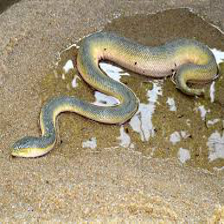

In [5]:
img = Image.open('img.jpg').resize(IMAGE_SHAPE)
img

In [6]:
img = np.array(img)/255.0
img.shape

(224, 224, 3)

In [7]:
result = classifier.predict(img[np.newaxis, ...])
result.shape

(1, 1001)

In [8]:
predicted_label_index = np.argmax(result)
predicted_label_index

66

In [9]:
image_labels = []
with open('ImageNetLabels.txt','r') as f:
    image_labels = f.read().splitlines()
image_labels[:5]    

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [10]:
image_labels[predicted_label_index]

'sea snake'

In [11]:
# so till now we did only classification from pretrained model like pickled model

In [12]:
dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
data_dir = keras.utils.get_file('flower_photos',origin=dataset_url ,cache_dir='.',untar=True)           #untar means unzip

'''data_dir = '../datasets/flower_photos'''

228818944/228813984 [==============================] - 2s 0us/step


"data_dir = '../datasets/flower_photos"

In [13]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

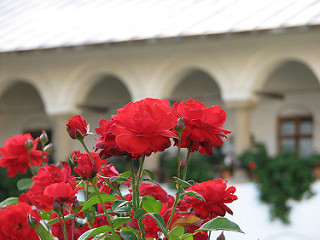

In [14]:
roses = list(data_dir.glob('roses/*.jpg'))[:5]
Image.open(roses[0])

In [15]:
flowers_images_dict = {
    'roses' : list(data_dir.glob('roses/*')),
    'daisy' : list(data_dir.glob('daisy/*')),
    'dandelion' : list(data_dir.glob('dandelion/*')),
    'sunflowers' : list(data_dir.glob('sunflowers/*')),
    'tulips' : list(data_dir.glob('tulips/*')),
}                                                           

In [16]:
flowers_labels_dict = {
    'roses':0,
    'daisy':1,
    'dandelion':2,
    'sunflowers':3,
    'tulips':4
}

In [17]:
flowers_images_dict['roses'][0]

PosixPath('datasets/flower_photos/roses/1461381091_aaaa663bbe_n.jpg')

In [18]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))
img.shape

(240, 320, 3)

In [19]:
cv2.resize(img,IMAGE_SHAPE).shape

(224, 224, 3)

In [20]:
X,y = [], []
for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,IMAGE_SHAPE)
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [21]:
X = np.array(X)
y = np.array(y)
X = X / 255

In [22]:
from sklearn.model_selection import train_test_split as tts
X_train,X_test,y_train,y_test = tts(X,y,random_state=0)

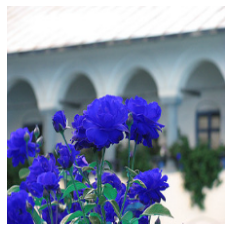

In [23]:
plt.axis('off')
plt.imshow(X[0])

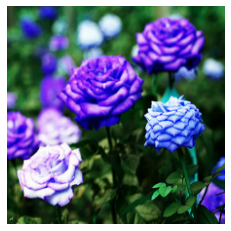

In [24]:
plt.axis('off')
plt.imshow(X[1])

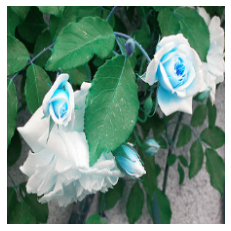

In [25]:
plt.axis('off')
plt.imshow(X[2])

In [26]:
predicted = classifier.predict(np.array([X[0],X[1],X[2]]))
predicted = np.argmax(predicted,axis=1)
predicted

array([717, 945, 739])

In [27]:
image_labels[739]

'pot'

In [28]:
#this gives the same model as the previous one except the last layer

feature_extractor_model_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
pretrained_model_without_top_layer = hub.KerasLayer(feature_extractor_model_url, input_shape = (224,224,3), trainable = False)

In [29]:
num_of_flowers = 5

model = tf.keras.Sequential([
      pretrained_model_without_top_layer,
      tf.keras.layers.Dense(num_of_flowers)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [30]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['acc']
)

model.fit(X_train,y_train,epochs=5)

Epoch 1/5
86/86 [==============================] - 51s 564ms/step - loss: 0.8089 - acc: 0.6897
Epoch 2/5
86/86 [==============================] - 49s 564ms/step - loss: 0.4157 - acc: 0.8528
Epoch 3/5
86/86 [==============================] - 49s 566ms/step - loss: 0.3241 - acc: 0.8957
Epoch 4/5
86/86 [==============================] - 49s 565ms/step - loss: 0.2719 - acc: 0.9110
Epoch 5/5
86/86 [==============================] - 49s 566ms/step - loss: 0.2350 - acc: 0.9277


In [31]:
model.evaluate(X_test,y_test)

29/29 [==============================] - 17s 561ms/step - loss: 0.3715 - acc: 0.8693


[0.3715156316757202, 0.8692810535430908]

In [33]:
predicted = model.predict(np.array([X[0],X[1],X[2]]))
predicted = np.argmax(predicted,axis=1)
predicted

array([0, 1, 0])